In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time

In [5]:
# Importar o dataframe, estes dados 
df = pd.read_csv("DadosNovos.csv",index_col=0)

C:\Users\marianna.oliveira\AppData\Local\Temp\ipykernel_11404\3197839621.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("DadosNovos.csv",index_col=0)


In [6]:
requisitos = pd.read_csv("RequisitosNovos.csv",index_col=0)

In [7]:
df = df[(df["011"] != '0.0') & (df["010"] != '0.0')]
df = df[(df["TIPOCHEQUE"] != 7) & (df["TIPOCHEQUE"] != 35) & (df["TIPOCHEQUE"] != 37) & (df["TIPOCHEQUE"] != 80) & (df["TIPOCHEQUE"] != 89)]

In [8]:
# LIMPEZA DOS DADOS FEITA:
# Tratar dos paths pois faltava o "C:\WORK" no inicio
# Foram preenchidos os valores nulos com "Não verificado" para facilitar
# Retirou-se as linhas em que todos os valores eram "Não verificado"
# Se dropasse os nulos ficavam com o dataset vazio lol
# Há umas colunas um bocado filler lá po final mas não tirei porque pode ser util idk, qualquer cena depois tira-se mas é um bocado irrelevante

df.head()

Dt.Extract           DBOrigem     OPERATIVA  \
0  2025-04-08 14:31:18.387  SIDOC_04_20250401  9 - Recebida   
1  2025-04-08 14:31:18.387  SIDOC_04_20250401  9 - Recebida   
2  2025-04-08 14:31:18.387  SIDOC_04_20250401  9 - Recebida   
3  2025-04-08 14:31:18.387  SIDOC_04_20250401  9 - Recebida   
4  2025-04-08 14:31:18.387  SIDOC_04_20250401  9 - Recebida   

         TIPO_REMESSA  BANCO  ID_DOCUMENTO     ZIB   NUM_CONTA  NUM_CHEQUE  \
0  000 - Não definido     43     715193287  430001  3213574888  7501018505   
1  000 - Não definido     43     715193288  430001  3213574888  9501017619   
2  000 - Não definido     43     715193289  430001  3213574888   301017446   
3  000 - Não definido     43     715193290  430001  3213574888  2401018349   
4  000 - Não definido     43     715193291  430001  3213574888  4201018347   

   MONTANTE  ...             072             075             081  \
0   1021.49  ...  Nao Verificado  Nao Verificado  Nao Verificado   
1   2000.00  ...  Nao Verificado  Nao Verificado  Nao Verificado   
2    567.69  ...  Nao Verificado  Nao Verificado  Nao Verificado   
3    181.31  ...  Nao Verificado  Nao Verificado  Nao Verificado   
4     94.91  ...  Nao Verificado  Nao Verificado  Nao Verificado   

              082             083             084             095  \
0  Nao Verificado  Nao Verificado  Nao Verificado  Nao Verificado   
1  Nao Verificado  Nao Verificado  Nao Verificado  Nao Verificado   
2  Nao Verificado  Nao Verificado  Nao Verificado  Nao Verificado   
3  Nao Verificado  Nao Verificado  Nao Verificado  Nao Verificado   
4  Nao Verificado  Nao Verificado  Nao Verificado  Nao Verificado   

              096             110             111  
0  Nao Verificado  Nao Verificado  Nao Verificado  
1  Nao Verificado  Nao Verificado  Nao Verificado  
2  Nao Verificado  Nao Verificado  Nao Verificado  
3  Nao Verificado  Nao Verificado  Nao Verificado  
4  Nao Verificado  Nao Verificado  Nao Verificado  

[5 rows x 47 columns]

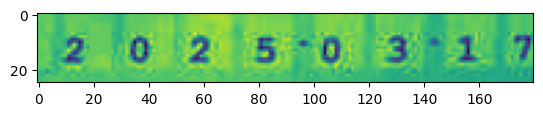

In [252]:
img = cv.imread(df['NOME_IMAGEM'].iloc[8],0)
x, y, w, h = 405, 153, 180, 25
img = img[y:y+h, x:x+w]
#x_1.append(img.shape[0])
#y_1.append(img.shape[1])
#print(img.shape[0])
#print(img.shape[1])
plt.imshow(img)

In [11]:
def rotacoes(image):
    angles = [-10, -5, -3, 3, 5, 10]
    angle = np.random.choice(angles)
    image = rotate_image(image,angle) 
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

In [27]:
# Esta função lê as imagens a partir do caminho e devolve um dataframe para treino do modelo.
# Como parâmetros tem:
#      - requisito (qual é o requisito)
#      - coordenadas (o recorte da imagem que querem)
#      - tamanho (tamanho da imagem)
#      - augmentatiom (caso True, faz 6 cópias da imagem com slight rotações, tamos a treinar com 50 mil imagens por isso não acho que seja preciso lol)
#      - verso (caso True, utiliza a imagem de trás do cheque em vez da frente, utilizem apenas quando for preciso treinar o verso)

def images_para_dataframe(requisito,coordenadas=0,tamanho=0,augmentation=False,verso=False):

    c = "NOME_IMAGEM"
    if verso:
        c = "NOME_IMAGEM_VERSO"

    # Mete apenas as colunas relevantes: id, imagem frente ou verso, requisito
    dp = df[['NUM_UNICO_DOCUMENTO_RECOLHIDO',c,requisito]]
    # Retira os "Não verificado" (são os valores nulos)
    dp = dp[dp[requisito] != "Não verificado"]
    dp = dp.reset_index(drop=True)

    imgs = []
    cont_bom = 0
    cont_mau = 0
    linhas_boas = []
    
    for i in range(len(dp[c])):
        linha = dp.iloc[i]
        imagem = cv.imread(dp[c][i],0)
        print("Imagens falhadas:",cont_mau)
        print("Imagens boas:",cont_bom)

        # Há muitas imagens que não são carregados corretamente porque há paths que não existem no computador da sibs mas estão no dataset
        # São ignoradas essas imagens, os contadores (cont_bom,cont_mau) é só para ter noção do número.
        if imagem is None:
           cont_mau += 1
           continue  
        else:
          cont_bom +=1
          # O "linhas_boas" são as linhas do dataset que tem paths de imagens que existem.
          linhas_boas.append(linha)
          if type(coordenadas) == tuple:
              x, y, w, h = coordenadas
              imagem = imagem[y:y+h, x:x+w]
          imagem = cv.resize(imagem, tamanho)
          imagem = np.expand_dims(imagem, axis=-1) 
          imgs.append(imagem)
            
          if augmentation:
             for _ in range(6):
                imagem = rotacoes(imagem)
                imgs.append(imagem)
                linhas_boas.append(linha)

    df_final = pd.DataFrame(linhas_boas)
    df_final["imagem"] = imgs
    # Faz das labels números inteiros e mete a coluna a chamar-se "label"
    df_final["label"] = [int(float(num)) for num in df_final[requisito]]
    df_final = df_final.drop(columns=[requisito])    
    
    return df_final
    

In [71]:
df_data = images_para_dataframe(requisito="022", coordenadas=(405, 153, 180, 25), tamanho=(139,25))

Imagens falhadas: 0
Imagens boas: 0
Imagens falhadas: 0
Imagens boas: 1
Imagens falhadas: 0
Imagens boas: 2
Imagens falhadas: 0
Imagens boas: 3
Imagens falhadas: 0
Imagens boas: 4
Imagens falhadas: 0
Imagens boas: 5
Imagens falhadas: 0
Imagens boas: 6
Imagens falhadas: 0
Imagens boas: 7
Imagens falhadas: 0
Imagens boas: 8
Imagens falhadas: 0
Imagens boas: 9
Imagens falhadas: 0
Imagens boas: 10
Imagens falhadas: 0
Imagens boas: 11
Imagens falhadas: 0
Imagens boas: 12
Imagens falhadas: 0
Imagens boas: 13
Imagens falhadas: 0
Imagens boas: 14
Imagens falhadas: 0
Imagens boas: 15
Imagens falhadas: 0
Imagens boas: 16
Imagens falhadas: 0
Imagens boas: 17
Imagens falhadas: 0
Imagens boas: 18
Imagens falhadas: 0
Imagens boas: 19
Imagens falhadas: 0
Imagens boas: 20
Imagens falhadas: 0
Imagens boas: 21
Imagens falhadas: 0
Imagens boas: 22
Imagens falhadas: 0
Imagens boas: 23
Imagens falhadas: 0
Imagens boas: 24
Imagens falhadas: 0
Imagens boas: 25
Imagens falhadas: 0
Imagens boas: 26
Imagens fal

In [72]:
df_data.head()

NUM_UNICO_DOCUMENTO_RECOLHIDO  \
0                 50871090039682   
1                 50870360039697   
2                 25090070210563   
3                 25090220041853   
4                 25090220041883   

                                         NOME_IMAGEM  \
0  C:\WORK\04\0043\25090\IMR\202503310002_2172509...   
1  C:\WORK\04\0043\25090\IMR\202503310002_2172509...   
2  C:\WORK\04\0043\25090\IMR\202503310002_2172509...   
3  C:\WORK\04\0043\25090\IMR\202503310002_2172509...   
4  C:\WORK\04\0043\25090\IMR\202503310002_2172509...   

                                              imagem  label  
0  [[[186], [188], [175], [169], [176], [177], [1...      1  
1  [[[185], [180], [173], [177], [174], [173], [1...      1  
2  [[[162], [160], [154], [153], [155], [158], [1...      1  
3  [[[157], [165], [169], [171], [173], [172], [1...      1  
4  [[[161], [162], [163], [162], [161], [162], [1...      1

In [74]:
df_data['label'].value_counts()

label
1    71427
0      206
Name: count, dtype: int64

In [76]:
# Dataset de treino, a coluna do num_unico é deixada MAS dont worry n vai po treino lmfao
# Essa coluna tem que ser mantida pq da jeito para depois vermos o cheque inteiro com um recorte da imagem, caso for necessário.

df_treino = df_data[["NUM_UNICO_DOCUMENTO_RECOLHIDO","label","imagem"]]
df_treino.head()

NUM_UNICO_DOCUMENTO_RECOLHIDO  label  \
0                 50871090039682      1   
1                 50870360039697      1   
2                 25090070210563      1   
3                 25090220041853      1   
4                 25090220041883      1   

                                              imagem  
0  [[[186], [188], [175], [169], [176], [177], [1...  
1  [[[185], [180], [173], [177], [174], [173], [1...  
2  [[[162], [160], [154], [153], [155], [158], [1...  
3  [[[157], [165], [169], [171], [173], [172], [1...  
4  [[[161], [162], [163], [162], [161], [162], [1...

In [81]:
# Antes de fazer upsample das imagens, apenas utilizamos metade das imagens positivas
# Pois se fizessemos upsampling iamos tar a treinar com 100 mil imagens
# Dividiu-se as imagens positivas na metade, metade vão para o treino e as outras são guardadas no "DatasetNãoutilizadoPositivos".
# Na próxima vez podemos treinar com todas.

df_treino_positivo = df_treino[df_treino["label"] == 1]
df_treino_positivo = df_treino.sample(frac=0.5, random_state=42)  

remaining_df = df_treino.drop(df_treino_positivo.index)

remaining_df.to_csv("DatasetNãoUtilizadoPositivosData.csv", index=False)

In [82]:
# Upsample das imagens negativas, tendo agora no dataset total 50 mil imagens

df_treino_negativo = df_treino[df_treino['label'] == 0]

df_negativo_upsampled = df_treino_negativo.sample(len(df_treino_positivo), replace=True, random_state=42)

df_balanced = pd.concat([df_treino_positivo, df_negativo_upsampled], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total images in balanced DataFrame: {len(df_balanced)}")

Total images in balanced DataFrame: 71632


In [85]:
# Divisão dos dados em treino/teste e pré-processamento das imagems para o treino

train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=2, stratify=df_balanced['label'])

x_train = np.stack(train_df['imagem'].values)
x_test = np.stack(test_df['imagem'].values)
y_train = np.array(train_df['label'])
y_test = np.array(test_df['label'])

#x_train = np.array([tf.image.rgb_to_grayscale(img) for img in x_train])
#x_test = np.array([tf.image.rgb_to_grayscale(img) for img in x_test])

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(tf.expand_dims(x, axis=-1)), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(tf.expand_dims(x, axis=-1)), y))

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [91]:
# Import do modelo
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense

# alterar o tamanho 
model = Sequential([

    # Input layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(25, 139, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Hidden layers
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Flatten layer
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),

    # Output layer for 2 classes
    Dense(1, activation='sigmoid')
])

In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=1,              
    restore_best_weights=True  
)

In [93]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [94]:
start = time.perf_counter()

model.fit(
    train_dataset,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_dataset
)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Epoch 1/10
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.9045 - loss: 1.0732 - val_accuracy: 0.9275 - val_loss: 0.2634
Epoch 2/10
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.9757 - loss: 0.1935 - val_accuracy: 0.9758 - val_loss: 0.1729
Epoch 3/10
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 47s 26ms/step - accuracy: 0.9823 - loss: 0.1657 - val_accuracy: 0.9698 - val_loss: 0.1987
Elapsed time: 135.657440 seconds


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


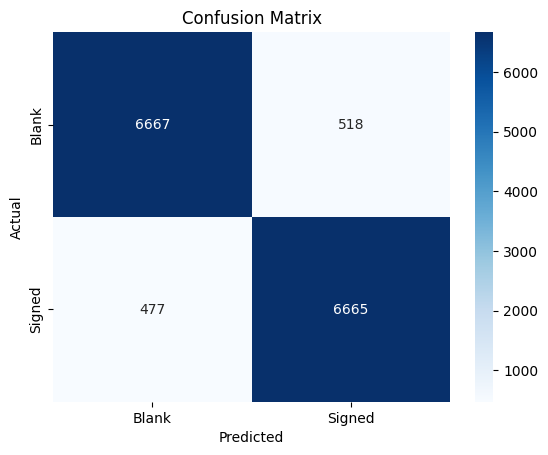

              precision    recall  f1-score   support

       Blank       0.93      0.93      0.93      7185
      Signed       0.93      0.93      0.93      7142

    accuracy                           0.93     14327
   macro avg       0.93      0.93      0.93     14327
weighted avg       0.93      0.93      0.93     14327



In [96]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blank', 'Signed'], yticklabels=['Blank', 'Signed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Blank', 'Signed']))

In [137]:
vazios = df[(df['022'] == 0.0) ^ (df['022'] == '0.0')]

In [99]:
# Ver quais foram as imagens que falharam
vazio_mas_assinado = []
assinado_mas_vazio = []
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
       if y_test[i] == 0:
           assinado_mas_vazio.append(i)
       else:
           vazio_mas_assinado.append(i)

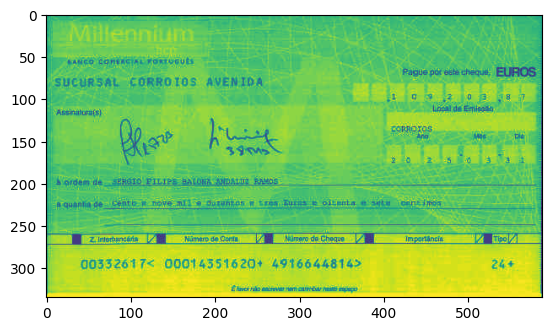

In [271]:
idx = test_df.iloc[vazio_mas_assinado[4]]["NUM_UNICO_DOCUMENTO_RECOLHIDO"]
cheque_inteiro = cv.imread(df[df["NUM_UNICO_DOCUMENTO_RECOLHIDO"] == idx]["NOME_IMAGEM"].iloc[0],0)
plt.imshow(cheque_inteiro)

In [277]:
df[df["NUM_UNICO_DOCUMENTO_RECOLHIDO"] == idx]['NOME_IMAGEM'].iloc[0]

'C:\\WORK\\04\\0033\\25091\\IMR\\202504010002_2172954_118_1.JPG'

In [273]:
model.save('ModeloDataSIBS.keras')

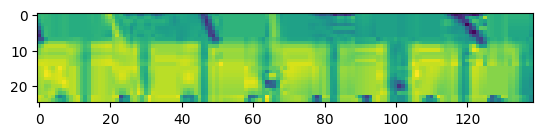

In [272]:
plt.imshow(test_df['imagem'].iloc[vazio_mas_assinado[5]])

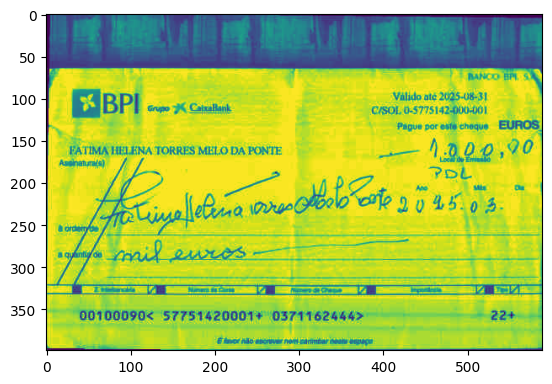